Import the neccessary libraries

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

Set a style for the plots for better visualization

In [36]:
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("viridis")

Data Loading and Exploration

In [37]:
try:
    df = pd.read_csv("data.csv")
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: The 'data.csv' was not found. Check the if it is present in the current directory")
    exit()


# Display the first few rows of the dataframe to understand its structure
print("Initial Data Preview")
df.head()

Data loaded successfully!
Initial Data Preview


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
# Get the summary of the dataframe to check for missing values and data types
print("Data Information")
print(df.info())

Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


Visualization before Training

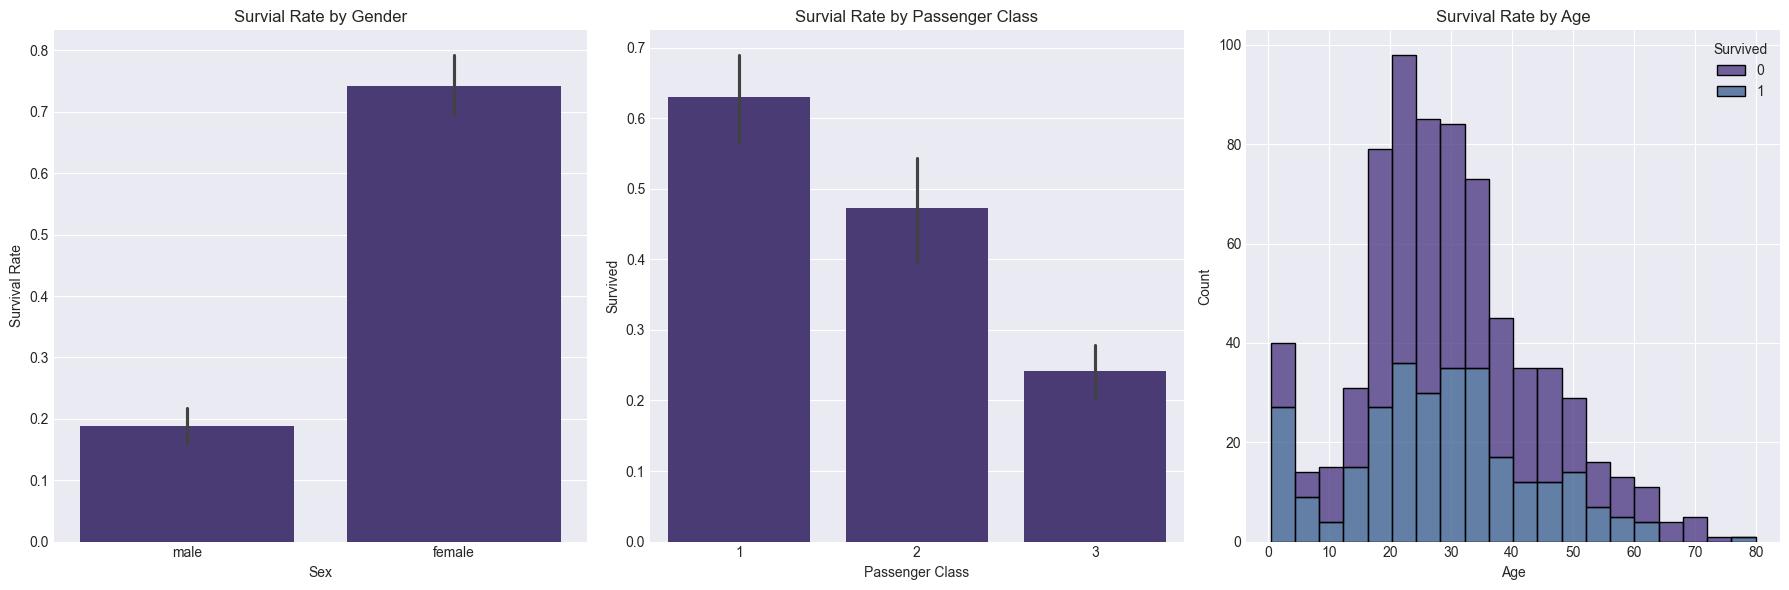

In [39]:
# Create a figure with subplots 
fig,axes = plt.subplots(1,3,figsize=(18,6))

# Plot 1 : Survival rate by Sex
sns.barplot(x="Sex",y="Survived",data=df,ax=axes[0])
axes[0].set_title("Survial Rate by Gender")
axes[0].set_xlabel("Sex")
axes[0].set_ylabel("Survival Rate")

# Plot 2: Survival rate by Passenger Class (Pclass)
sns.barplot(x="Pclass",y="Survived",data=df,ax=axes[1])
axes[1].set_title("Survial Rate by Passenger Class")
axes[1].set_xlabel("Passenger Class")
axes[0].set_ylabel("Survival Rate")

# Plot 3: Survival rate by Age distriution (using a histogram)
sns.histplot(x="Age",hue="Survived",data=df,multiple="stack",ax=axes[2])
axes[2].set_title("Survival Rate by Age")
axes[2].set_xlabel("Age")
axes[2].set_ylabel("Count")

# Adjust layout to prevent titles from overlapping
plt.tight_layout()

# Show the plots 
plt.show()

Data Preprocessing and Feature Engineering

In [40]:
# Check for missing values
df_missing = df.isnull().sum()
print("Missing Values")
print(df_missing)

# Change the missing values in the "Age" column to 0
df["Age"] = df["Age"].fillna(0)

# Change the missing values in the "Cabin" column to "-"
df["Cabin"] = df["Cabin"].fillna("-")

# Change the missing values in the "Embarked" column to "-"
df["Embarked"] = df["Embarked"].fillna("-")

# Check for duplicated rows
df_duplicated = df.duplicated().sum()
print("Duplicated Rows")
print(df_duplicated)

# Define the features (X) and the target variable (y)
features = ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]
target = "Survived"

X = df[features]
y = df[target]

# Define the features are numerical and which are categorical
numerical_features = ["Age","Fare","SibSp","Parch"]
categorical_features = ["Pclass","Sex","Embarked"]

# Create a Preprocessing pipeline
# The pipeline will handle missing values, scaling anfd one-hot encoding
numerical_transformer = Pipeline(steps=[
    # Impute missing numerical values with the mean
    ("imputer",SimpleImputer(strategy="mean")),
    # Standardize features by removing the mean and scaling to unit variance
    ("scaler",StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    # Impute missing categorical values with the most frequent value
    ("imputer",SimpleImputer(strategy="most_frequent")),
    # One-hot encode categorical features to numerical format
    ("onehot",OneHotEncoder(handle_unknown="ignore"))
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num",numerical_transformer,numerical_features),
        ("cat",categorical_transformer,categorical_features)
    ]
)

Missing Values
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Duplicated Rows
0


Training and Evaluating Models

In [41]:
print("Training and evaluating various clssification models.....")

# Dictionary to store the models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-nearest Neighbours": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Dictionary to store the models
performance_metrics = {
    "Accuracy": [],
    "Precison": [],
    "Recall": [],
    "F1 Score": []
}

# Split the data into training and testing sets (80% training, 20% testing)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Loop through each model to train and evaluate
trained_models = {}
for name,model in models.items():
    print(f" Training {name}.....")

    # Create a full pipeline that first preprocesses, then trains the model
    full_pipeline = Pipeline(steps=[("preprocessor",preprocessor),
                                    ("classifier",model)])
    
    # Fit the pipeline to the training data
    full_pipeline.fit(X_train,y_train)
    trained_models[name] = full_pipeline

    # Make predictions on the test set
    y_pred = full_pipeline.predict(X_test)

    # Calculate and store the performance metrics
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)

    performance_metrics["Accuracy"].append(accuracy)
    performance_metrics["Precison"].append(precision)
    performance_metrics["Recall"].append(recall)
    performance_metrics["F1 Score"].append(f1)


    print(f"     - {name} Metrics")
    print(f"     Accuracy: {accuracy:.4f}")
    print(f"     Precison: {precision:.4f}")
    print(f"     Recall: {recall:.4f}")
    print(f"     F1 Score: {f1:.4f}")
    print("-"* 30)


# Create a DataFrame to display the performance metrics clearly
metrics_df = pd.DataFrame(performance_metrics,index=models.keys())
print("Model Performance Summary:")
print(metrics_df.sort_values(by="Accuracy",ascending=False))

Training and evaluating various clssification models.....
 Training Logistic Regression.....
     - Logistic Regression Metrics
     Accuracy: 0.7765
     Precison: 0.7500
     Recall: 0.6892
     F1 Score: 0.7183
------------------------------
 Training K-nearest Neighbours.....
     - K-nearest Neighbours Metrics
     Accuracy: 0.8045
     Precison: 0.7600
     Recall: 0.7703
     F1 Score: 0.7651
------------------------------
 Training Support Vector Machine.....
     - Support Vector Machine Metrics
     Accuracy: 0.8268
     Precison: 0.8209
     Recall: 0.7432
     F1 Score: 0.7801
------------------------------
 Training Decision Tree.....
     - Decision Tree Metrics
     Accuracy: 0.7765
     Precison: 0.7237
     Recall: 0.7432
     F1 Score: 0.7333
------------------------------
 Training Random Forest.....
     - Random Forest Metrics
     Accuracy: 0.8101
     Precison: 0.7941
     Recall: 0.7297
     F1 Score: 0.7606
------------------------------
Model Performance Summa

Visulaization of Model Performance (After Training)

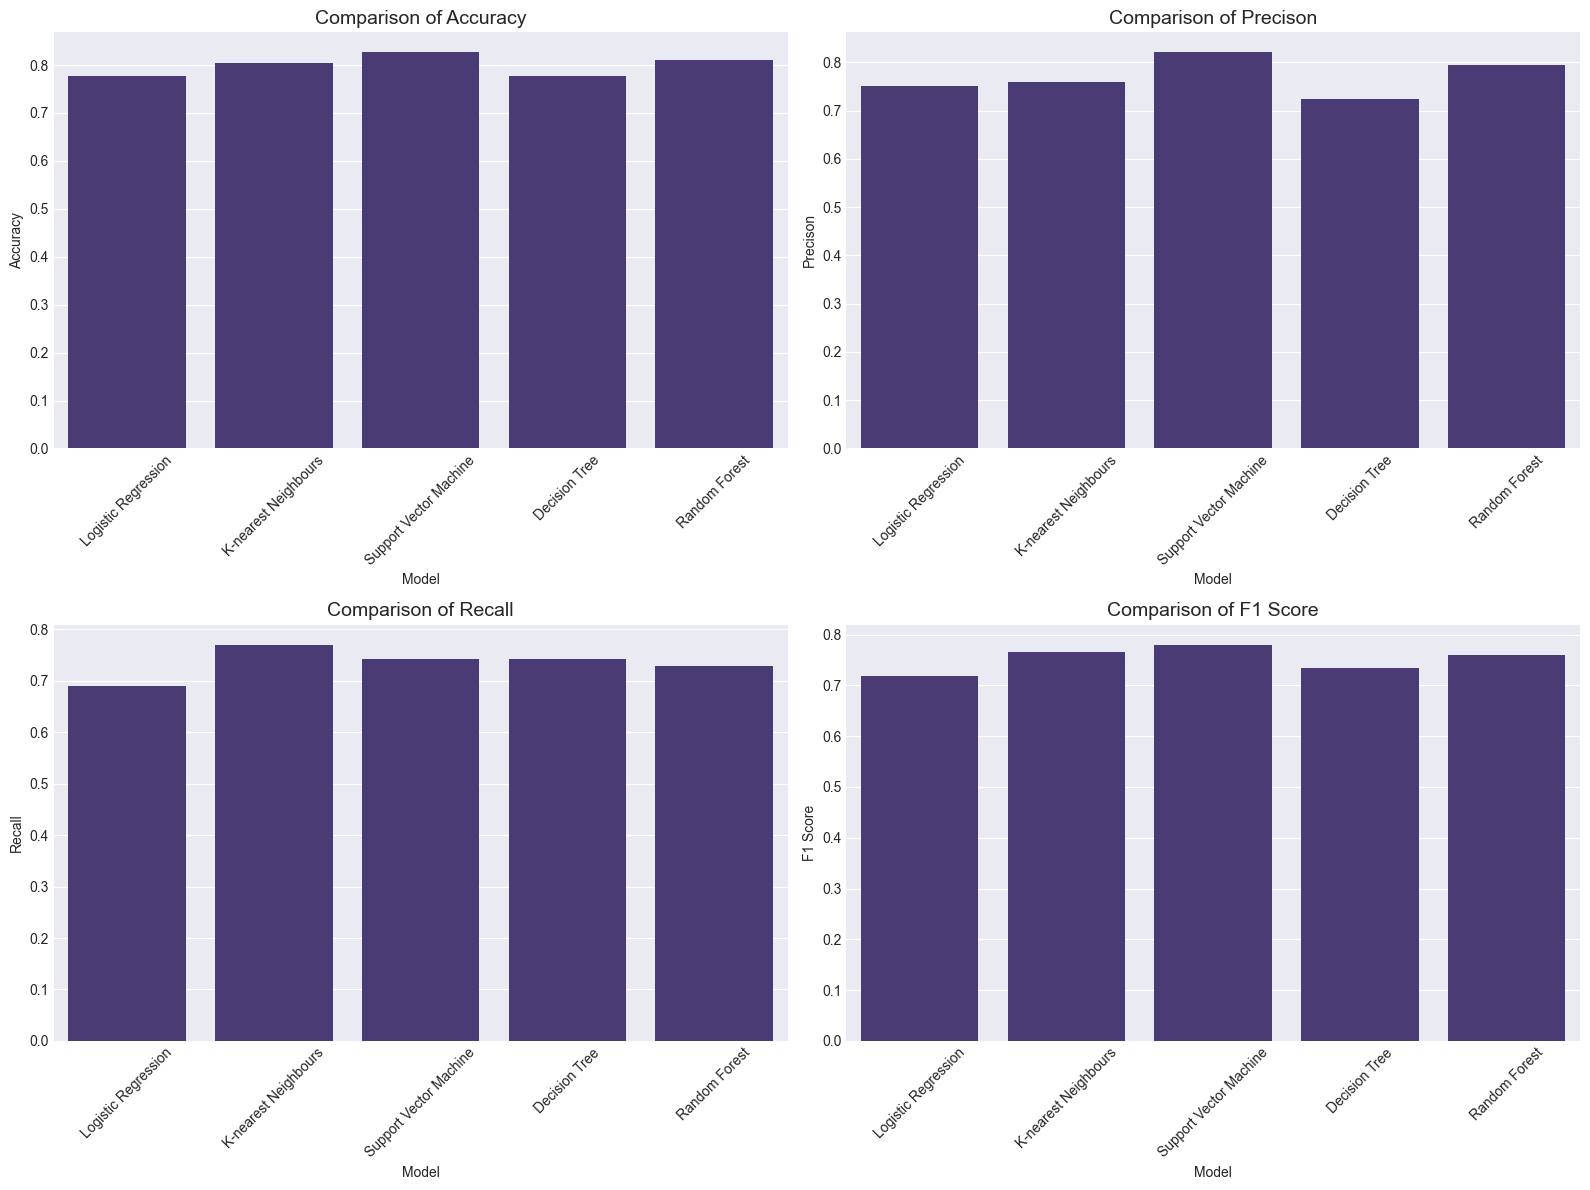

In [42]:
# Create a figure with subplots for each metric
fig,axes = plt.subplots(2,2,figsize=(16,12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each metric and plot a bar chart
for i, metric in enumerate(performance_metrics.keys()):
    sns.barplot(x=metrics_df.index,y=metrics_df[metric],ax=axes[i])
    axes[i].set_title(f"Comparison of {metric}", fontsize=14)
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Model")
    # Rotate x-axis labels for readablity
    axes[i].tick_params(axis="x",rotation=45)

# Adjust layut to prevent titles from overlapping
plt.tight_layout()

# Show the plots
plt.show()

Find the best Model

In [43]:
# Find the best model based on F1-Score (a good balance of precison and recall)
best_model_name = metrics_df["F1 Score"].idxmax()
best_model = trained_models[best_model_name]
print(f"The best performing model based on F1 Score is {best_model_name}")

The best performing model based on F1 Score is Support Vector Machine


Intercative User Prediction

In [ ]:
print("Now, let's make a prediction for a new passenger using the best model")
print("Please provide the following information:")

try:
    # Get user input for each feature
    pclass_input = int(input("Enter Passenger Class (1, 2, or 3):"))
    sex_input = (input("Enter Sex (male or female):"))
    age_input = float(input("Enter Age: "))
    sibsp_input = int(input("Enter number of Siblings/Spouses Aboard:"))
    parch_input = int(input("Enter number of Parents/Children Aboard:"))
    fare_input = float(input("Enter Fare: "))
    embarked_input = input("Enter Port of Emabarkation (C, Q, or S):")

    # Create a DataFrame with the user input
    user_data = pd.DataFrame([[pclass_input, sex_input, age_input, sibsp_input,
                               parch_input, fare_input, embarked_input]],
                             columns=features)
    # Use the best model to make a prediction
    prediction = best_model.predict(user_data)

    # Interpret the prediction result
    if prediction[0] == 1:
        print("Prediction: The Passenger would likely have SURVIVED.")
    else:
        print("Prediction: The passenger would likely have NOT SURVIVED.")

    # Show the confidence of the prediction if possible
    if hasattr(best_model, "predict_proba"):
        prediction_proba = best_model.predict_proba(user_data)
        print(f"Survival Probability: {prediction_proba[0][1]:.2f}")
        print(f"Non-Survival Probability: {prediction_proba[0][0]:.2f}")
    else:
        print("Probability prediction is not available for this model.")

except ValueError:
    print("Invalid input. Please ensure you enter the correct data types.")